In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/garipov/decomposed/")

In [3]:
ylim = (0.75,0.925)

In [4]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 375


In [5]:
# from datetime import datetime

# dts = [datetime.fromtimestamp(int(x)) for x in folders]
# print(max(dts))
# print(min(dts))

In [6]:
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

print(len(paths))

375


In [7]:
# baseline

baseline_path = Path("/bigdata/cifar10/logs/garipov/baselines/1647358615/gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue")
# baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result

{'best_epoch': 38,
 'best_train_acc': 0.9749333333333333,
 'best_valid_acc': 0.9078,
 'best_valid_loss': 0.003568341651931405,
 'test_acc': 0.891,
 'test_loss': 0.004007616302371025,
 'n_param': 557642,
 'model_name': 'gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue'}

In [8]:
from tddl.post_processing.factorized_model import process_factorized_networks

# process_factorized_networks(paths, baseline_path)

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [9]:
from tddl.post_processing.path_utils import paths_to_df

df = paths_to_df(paths)
print(len(df))
df.head()

375


,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,test_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
0,conv2,2,0.656228,0.000476,17.545992,2,tt,0.61,0.8832,0.7686,0.7507,530187,0.8770,0.0001,sgd,946.326234,3158.132243,65536.0,0.299733,0.014440
1,conv2,2,0.162229,0.000118,4.337635,2,tucker,0.9,0.9062,0.9026,0.8900,553952,0.8900,0.0001,sgd,152.337169,3158.132243,65536.0,0.048261,0.002324
2,conv2,2,0.162229,0.000118,4.337635,2,tucker,0.9,0.9060,0.9026,0.8900,553952,0.8905,0.0001,sgd,152.337076,3158.132243,65536.0,0.048261,0.002324
3,conv3,4,0.134625,0.000066,4.839327,4,cp,0.75,0.8888,0.9070,0.8905,539435,0.8728,0.0001,sgd,30.008520,1506.304621,28800.0,0.019925,0.001042
4,conv5,8,0.745227,0.000224,33.096771,8,tt,1.22,0.8728,0.6980,0.6857,446667,0.8644,0.0001,sgd,257.245890,550.282592,6272.0,0.467875,0.041015


In [10]:
df['rank'] = df['rank'].astype(float, copy=False)
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layers_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df.head()

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact
0,conv2,2,0.656228,0.000476,17.545992,2,tt,0.61,0.8832,0.7686,...,0.0001,sgd,946.326234,3158.132243,65536.0,0.299733,0.014440,tt-0.61,tt-2,2-tt
1,conv2,2,0.162229,0.000118,4.337635,2,tucker,0.90,0.9062,0.9026,...,0.0001,sgd,152.337169,3158.132243,65536.0,0.048261,0.002324,tucker-0.9,tucker-2,2-tucker
2,conv2,2,0.162229,0.000118,4.337635,2,tucker,0.90,0.9060,0.9026,...,0.0001,sgd,152.337076,3158.132243,65536.0,0.048261,0.002324,tucker-0.9,tucker-2,2-tucker
3,conv3,4,0.134625,0.000066,4.839327,4,cp,0.75,0.8888,0.9070,...,0.0001,sgd,30.008520,1506.304621,28800.0,0.019925,0.001042,cp-0.75,cp-4,4-cp
4,conv5,8,0.745227,0.000224,33.096771,8,tt,1.22,0.8728,0.6980,...,0.0001,sgd,257.245890,550.282592,6272.0,0.467875,0.041015,tt-1.22,tt-8,8-tt


In [11]:
df['test_error_before_ft'] = 1 - df.test_acc_before_ft
df['test_error'] = 1 - df.test_acc
df['valid_error_before_ft'] = 1 - df.valid_acc_before_ft
df['valid_error'] = 1 - df.valid_acc

df['log_test_error_before_ft'] = np.log(df.test_error_before_ft)
df['log_test_error'] = np.log(df.test_error)
df['log_valid_error_before_ft'] = np.log(df.valid_error_before_ft)
df['log_valid_error'] = np.log(df.valid_error)

In [12]:
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layers_fact':"category",
})

## Approximation error on the weights

In [13]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

ValueError: Could not interpret value `error` for parameter `y`

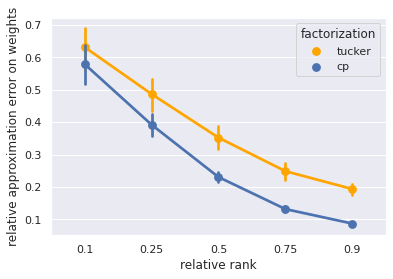

In [ ]:
ax = sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.set(xlabel='relative rank', ylabel='relative approximation error on weights')

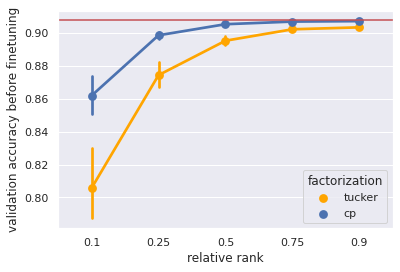

In [ ]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative rank', ylabel='validation accuracy before finetuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

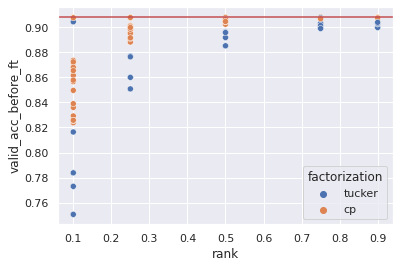

In [19]:
ax = sns.scatterplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

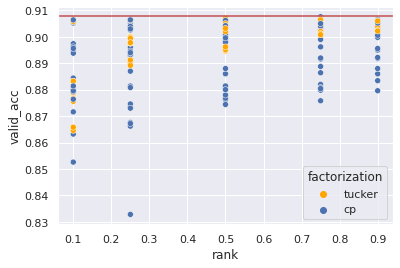

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

[Text(0.5, 0, 'relative rank'),
 Text(0, 0.5, 'validation accuracy after finetuning')]

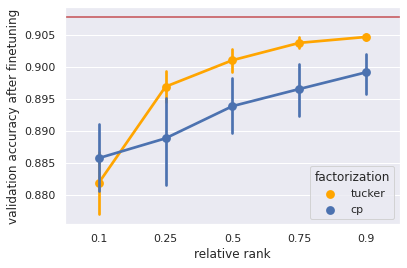

In [21]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='validation accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

[Text(0.5, 0, 'relative rank'), Text(0, 0.5, 'test accuracy after finetuning')]

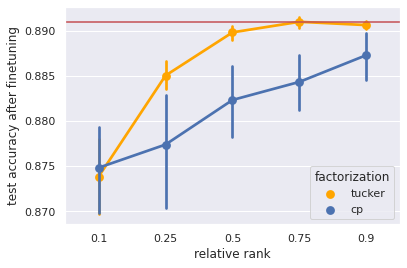

In [22]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='test accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

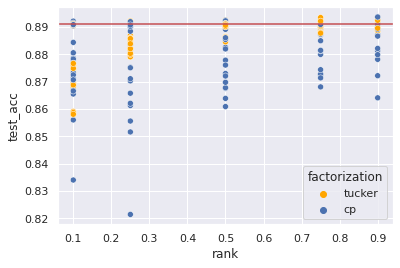

In [23]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['test_acc'], color='r')

In [24]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

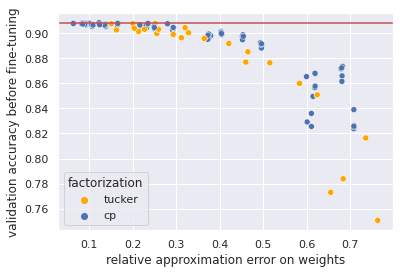

In [26]:
ax = sns.scatterplot(
    x="error", y="valid_acc_before_ft", 
    hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

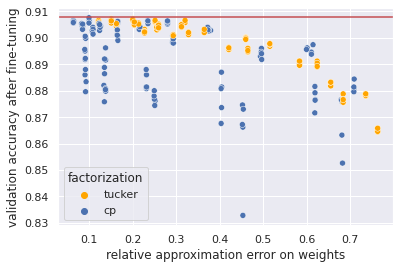

In [27]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

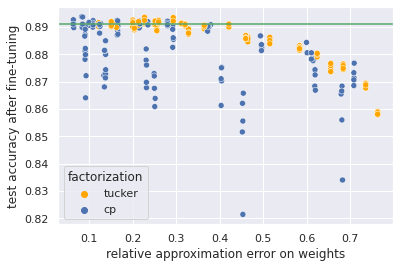

In [28]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

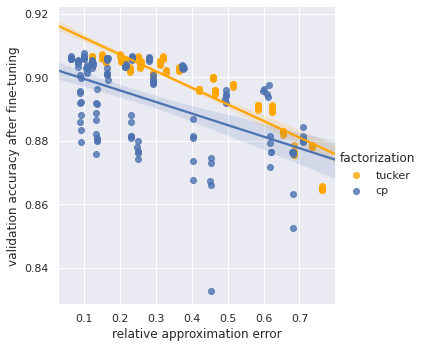

In [29]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')
# g.axhline(baseline_result['valid_acc'], color='g')

In [30]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact
0,conv2,2,0.162229,2,tucker,0.90,0.9062,0.9026,553952,0.8900,0.0001,sgd,152.337169,3158.132243,65536.0,0.048261,0.002324,tucker-0.9,tucker-2,2-tucker
1,conv2,2,0.162229,2,tucker,0.90,0.9060,0.9026,553952,0.8905,0.0001,sgd,152.337076,3158.132243,65536.0,0.048261,0.002324,tucker-0.9,tucker-2,2-tucker
2,conv3,4,0.134625,4,cp,0.75,0.8888,0.9070,539435,0.8728,0.0001,sgd,30.008520,1506.304621,28800.0,0.019925,0.001042,cp-0.75,cp-4,4-cp
3,conv2,2,0.125842,2,cp,0.75,0.9044,0.9076,548588,0.8914,0.0001,sgd,28.002705,3158.132243,65536.0,0.008862,0.000427,cp-0.75,cp-2,2-cp
4,conv4,6,0.464770,6,tucker,0.50,0.8960,0.8852,483277,0.8861,0.0001,sgd,173.677206,993.765087,28800.0,0.174963,0.006030,tucker-0.5,tucker-6,6-tucker


In [31]:
# g = sns.lmplot(x="error", y="test_acc", 
#    hue="fact_rank", 
#    data=df,
#    truncate=False, 
#    # palette=['orange','b'],
# )
# g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g.set(ylim=(0.935, 0.945))

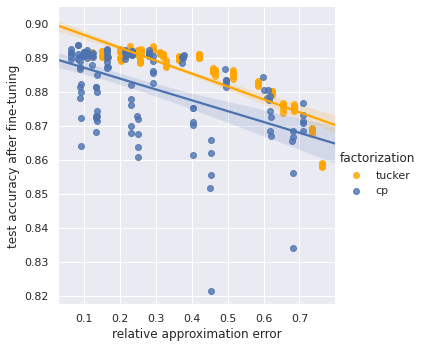

In [32]:
ax = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
ax.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')


In [33]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

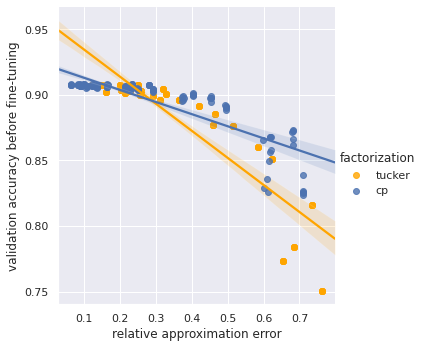

In [34]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [35]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
4,conv4,6,0.464770,6,tucker,0.5,0.8960,0.8852,483277,0.8861,0.0001,sgd,173.677206,993.765087,28800.0,0.174963,0.006030
7,conv5,8,0.251377,8,cp,0.5,0.8762,0.9046,484089,0.8639,0.0001,sgd,36.529098,550.282592,6272.0,0.066441,0.005824
15,conv4,6,0.464770,6,tucker,0.5,0.8960,0.8852,483277,0.8865,0.0001,sgd,173.677197,993.765087,28800.0,0.174963,0.006030
16,conv2,2,0.215367,2,cp,0.5,0.9036,0.9062,539408,0.8915,0.0001,sgd,63.354517,3158.132243,65536.0,0.020052,0.000967
17,conv4,6,0.291815,6,cp,0.5,0.8988,0.9028,484089,0.8826,0.0001,sgd,58.797859,993.765087,28800.0,0.059231,0.002042
19,conv2,2,0.311969,2,tucker,0.5,0.9044,0.8964,539477,0.8911,0.0001,sgd,295.577820,3158.132243,65536.0,0.093632,0.004510
26,conv5,8,0.420947,8,tucker,0.5,0.8962,0.8918,483277,0.8911,0.0001,sgd,121.659434,550.282592,6272.0,0.221295,0.019397
30,conv6,10,0.199976,10,tucker,0.5,0.9072,0.9076,483277,0.8926,0.0001,sgd,10.472476,108.647655,6272.0,0.096721,0.001670
32,conv2,2,0.215132,2,cp,0.5,0.9032,0.9070,539408,0.8922,0.0001,sgd,66.775112,3158.132243,65536.0,0.021135,0.001019
40,conv2,2,0.216328,2,cp,0.5,0.9034,0.9054,539408,0.8905,0.0001,sgd,68.721059,3158.132243,65536.0,0.021751,0.001049


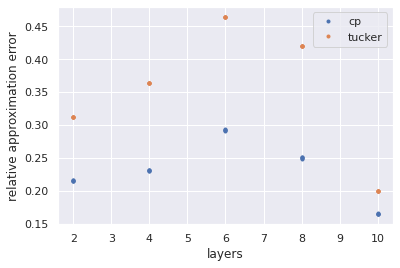

In [36]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [37]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [38]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

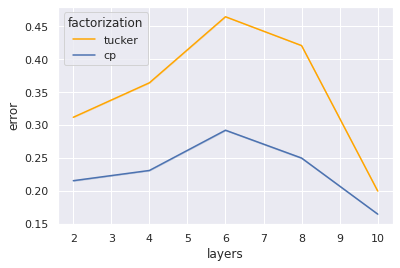

In [39]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
ax = sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

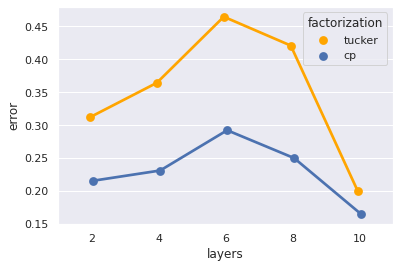

In [40]:
ax = sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

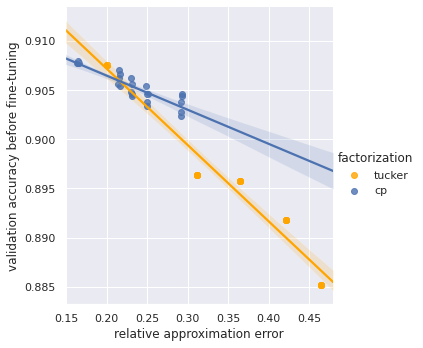

In [41]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

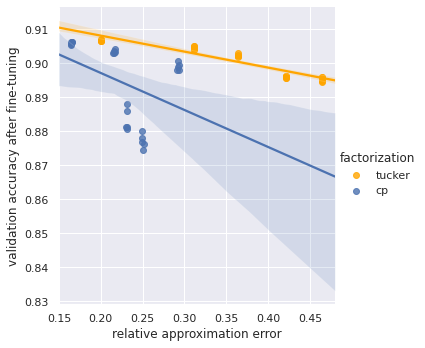

In [42]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

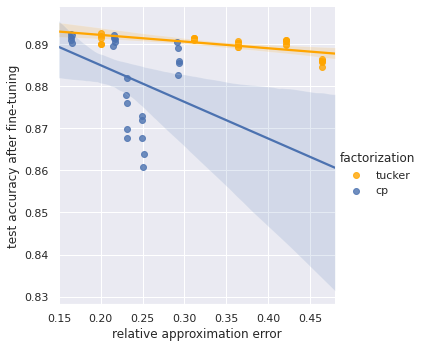

In [43]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

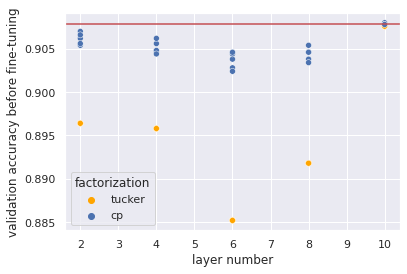

In [44]:
ax = sns.scatterplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    # dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

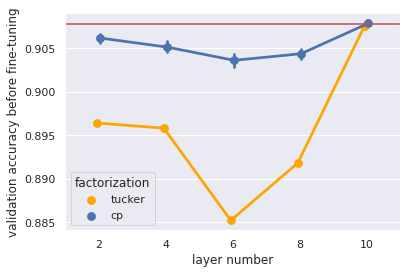

In [45]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy after fine-tuning')]

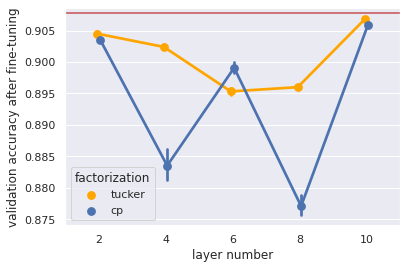

In [46]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')
# ax.set(ylim=(0.908, 0.9220))


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

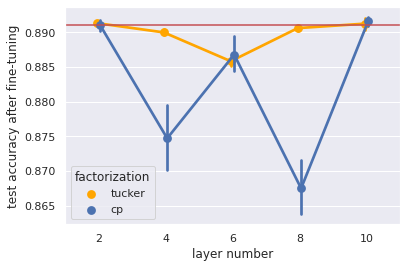

In [47]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [48]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
245    False
246    False
247    False
248    False
249    False
Name: factorization, Length: 250, dtype: bool

In [49]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact


In [50]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

# df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 2 & 0.10 &   0.001397 &  0.002634 \\
       &    & 0.25 &   0.000555 &  0.000921 \\
       &    & 0.50 &   0.000415 &  0.000958 \\
       &    & 0.75 &   0.001006 &  0.001453 \\
       &    & 0.90 &   0.000865 &  0.001976 \\
       & 4 & 0.10 &   0.003730 &  0.004736 \\
       &    & 0.25 &   0.007548 &  0.005683 \\
       &    & 0.50 &   0.003264 &  0.005855 \\
       &    & 0.75 &   0.006306 &  0.005947 \\
       &    & 0.90 &   0.004744 &  0.007284 \\
       & 6 & 0.10 &   0.001946 &  0.003091 \\
       &    & 0.25 &   0.001591 &  0.002018 \\
       &    & 0.50 &   0.001145 &  0.003163 \\
       &    & 0.75 &   0.001421 &  0.001272 \\
       &    & 0.90 &   0.001016 &  0.000915 \\
       & 8 & 0.10 &   0.010739 &  0.014303 \\
       &    & 0.25 &   0.017133 &  0.017603 \\
       &    & 0.50 &   0.002086 &  0.005195 \\
       &    & 

## Analysis on the features space

### Relative Norm

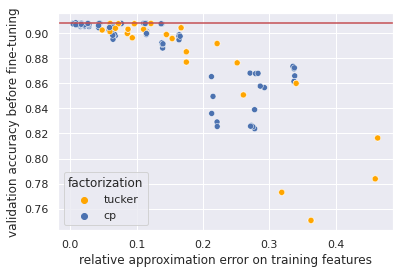

In [51]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
     hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

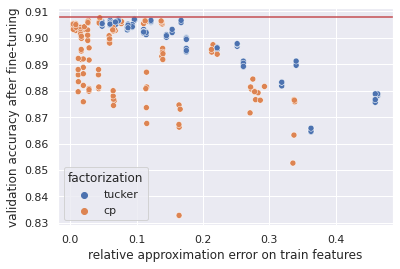

In [52]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

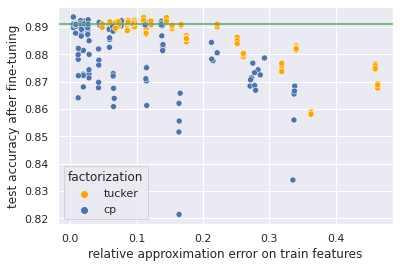

In [53]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

### Scaled Norm

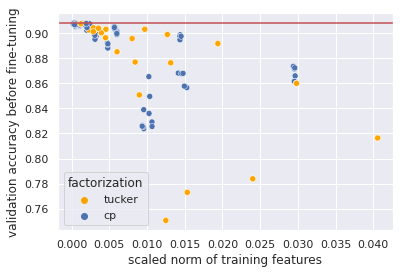

In [54]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

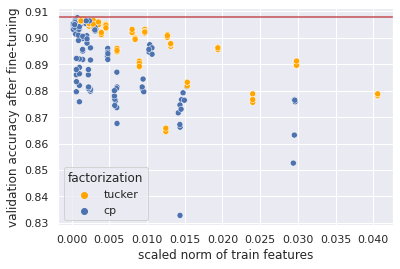

In [55]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

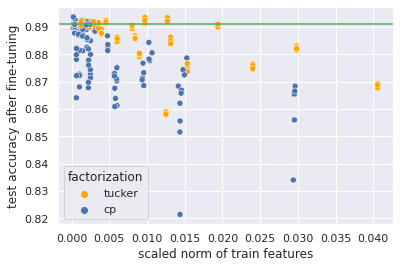

In [56]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

### Norm of Difference

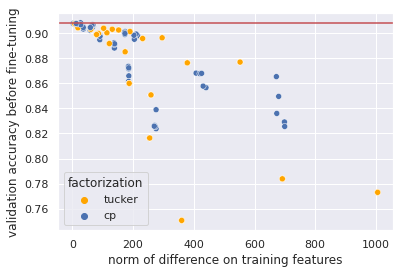

In [57]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

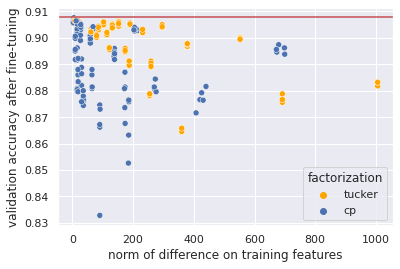

In [58]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

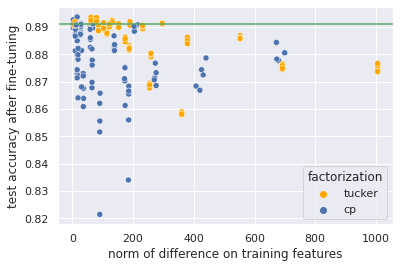

In [59]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

In [60]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

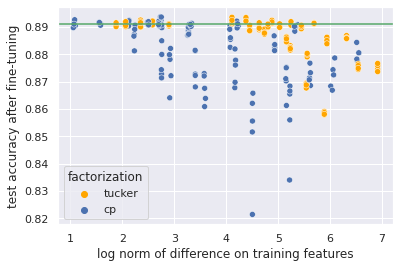

In [61]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='log norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))

In [62]:
df['log_test_acc'] = np.log(df.test_acc)

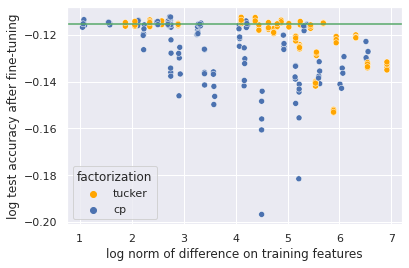

In [63]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='log norm of difference on training features', ylabel='log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))

# Per Layer

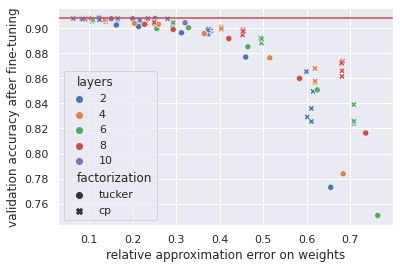

In [64]:
ax = sns.scatterplot(x="error", y="valid_acc_before_ft",
    hue="layers",
    style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))

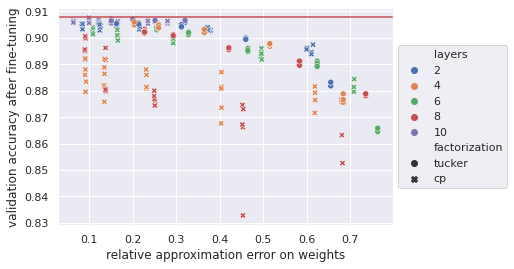

In [65]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
    
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

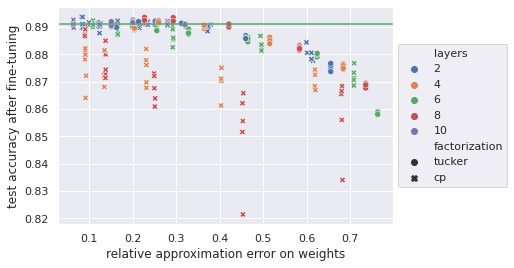

In [66]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="layers",
    style="factorization", 
    data=df,
    # palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Feature Space

### Relative Norm

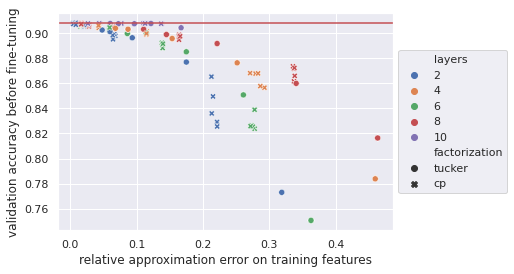

In [67]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

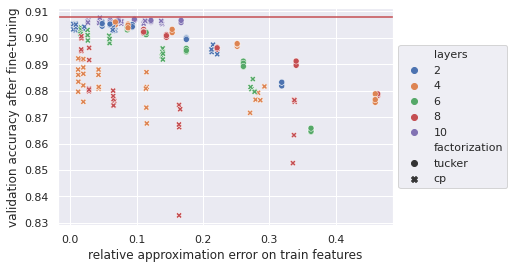

In [68]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

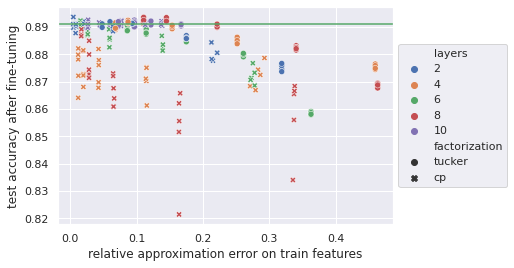

In [69]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Scaled Norm

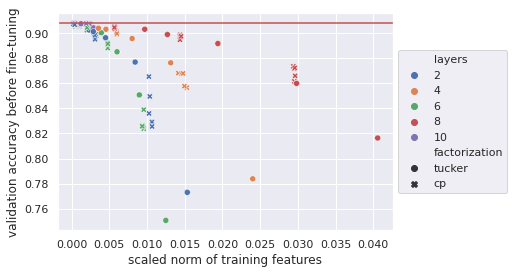

In [70]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

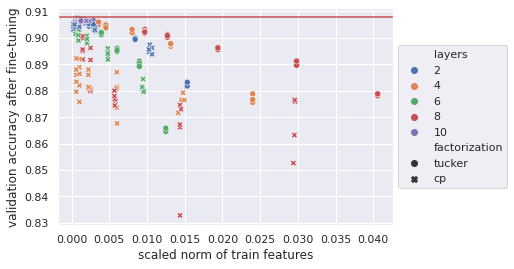

In [71]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

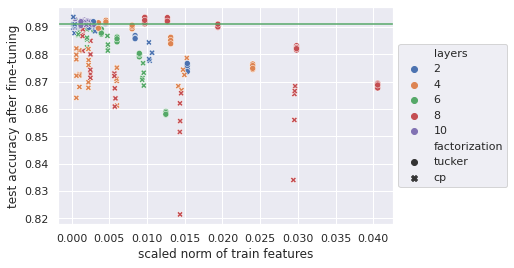

In [72]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Norm of Difference

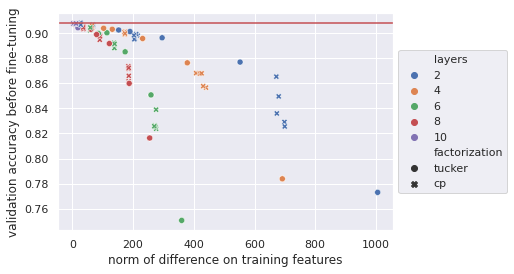

In [73]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

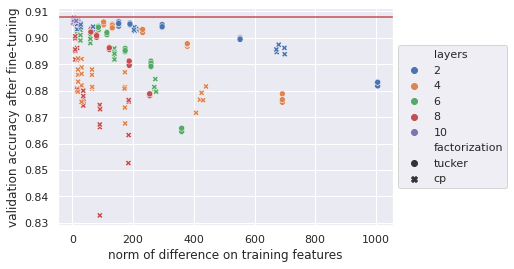

In [74]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

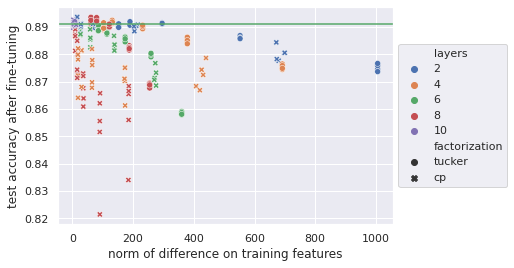

In [75]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [76]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

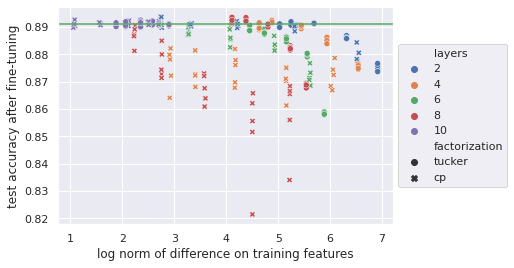

In [77]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='log norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [78]:
df['log_test_acc'] = np.log(df.test_acc)

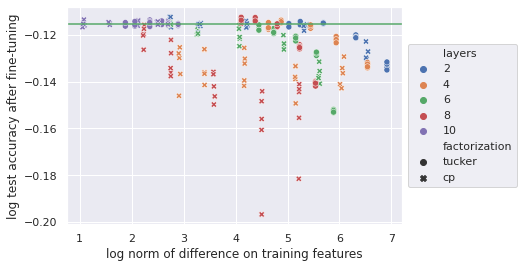

In [79]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='log norm of difference on training features', ylabel='log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

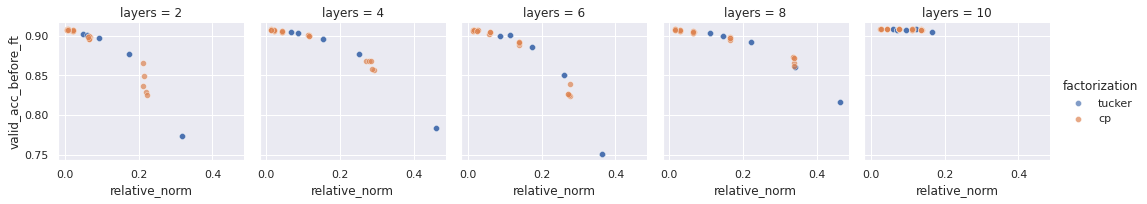

In [80]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc_before_ft", alpha=.7)
g.add_legend()

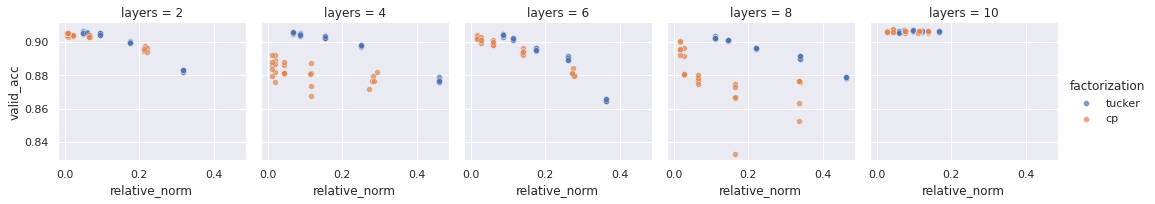

In [81]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc", alpha=.7)
g.add_legend()

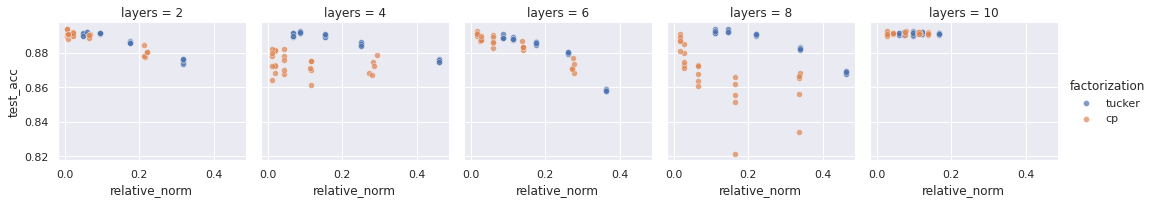

In [82]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "test_acc", alpha=.7)
g.add_legend()
# g.axhline(np.log(baseline_result['test_acc']), color='g')

In [83]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'error': 'Relative norm on weights',
    'relative_norm': 'Relative norm on training features',
    'scaled_norm': 'Scaled norm on training features',
    'norm_diff': 'Norm of the difference between training features',
    'log_norm_diff': 'Log norm of the difference between training features',
}

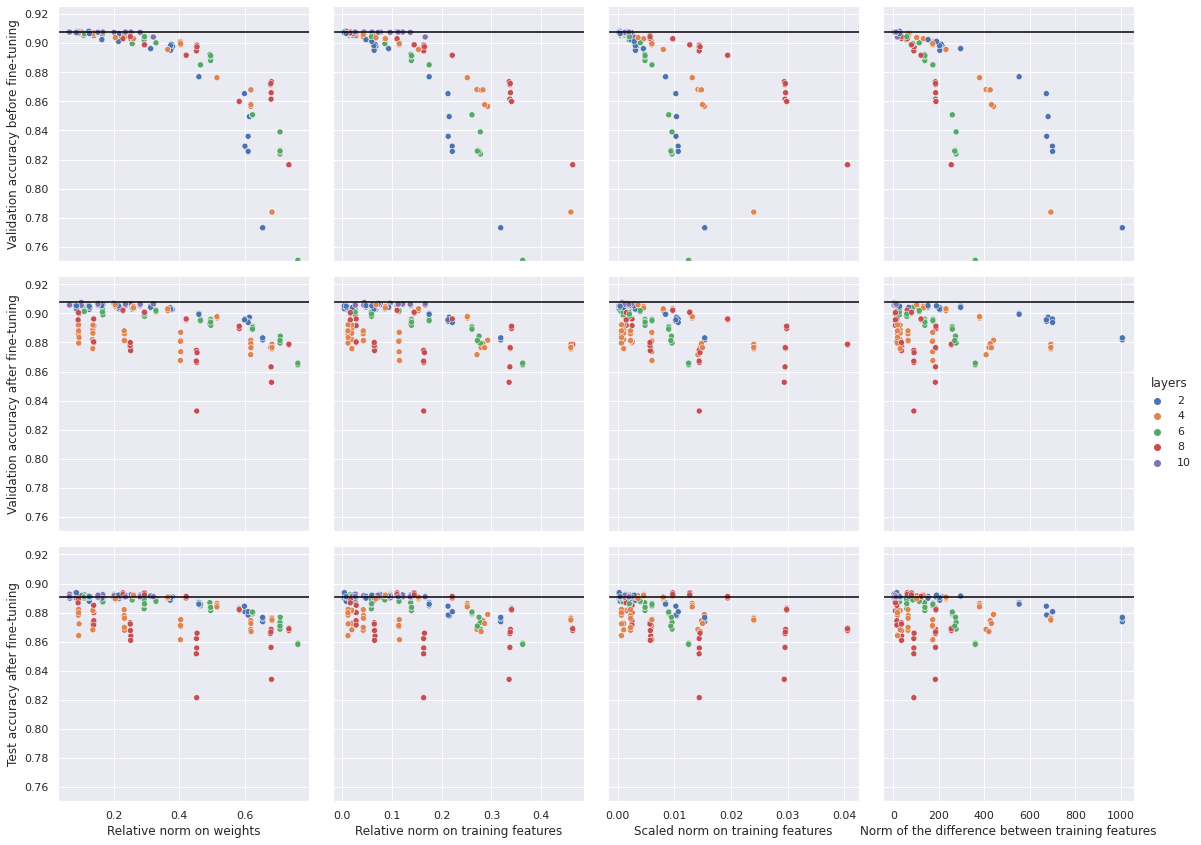

In [84]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])



/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f5554ebb370> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


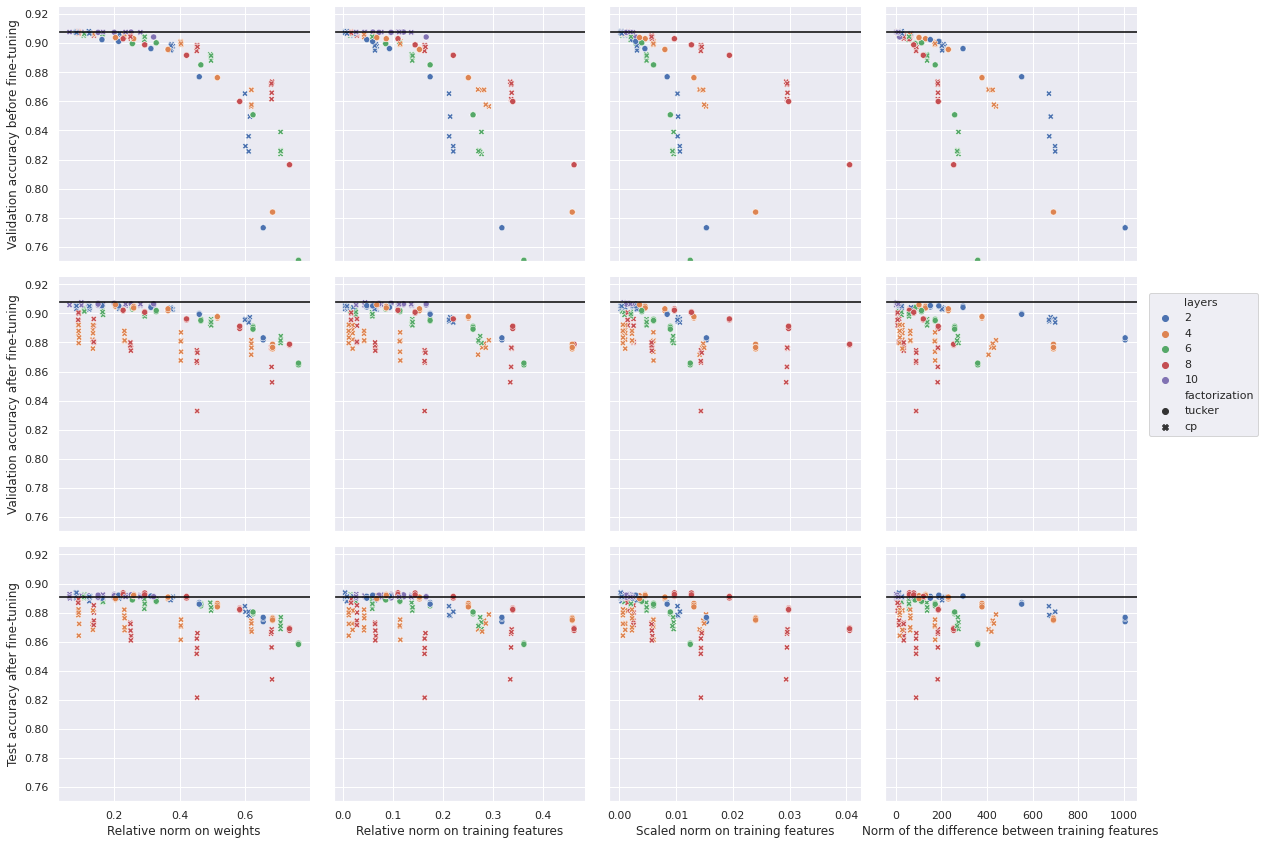

In [85]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=ylim)
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f555004b0d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


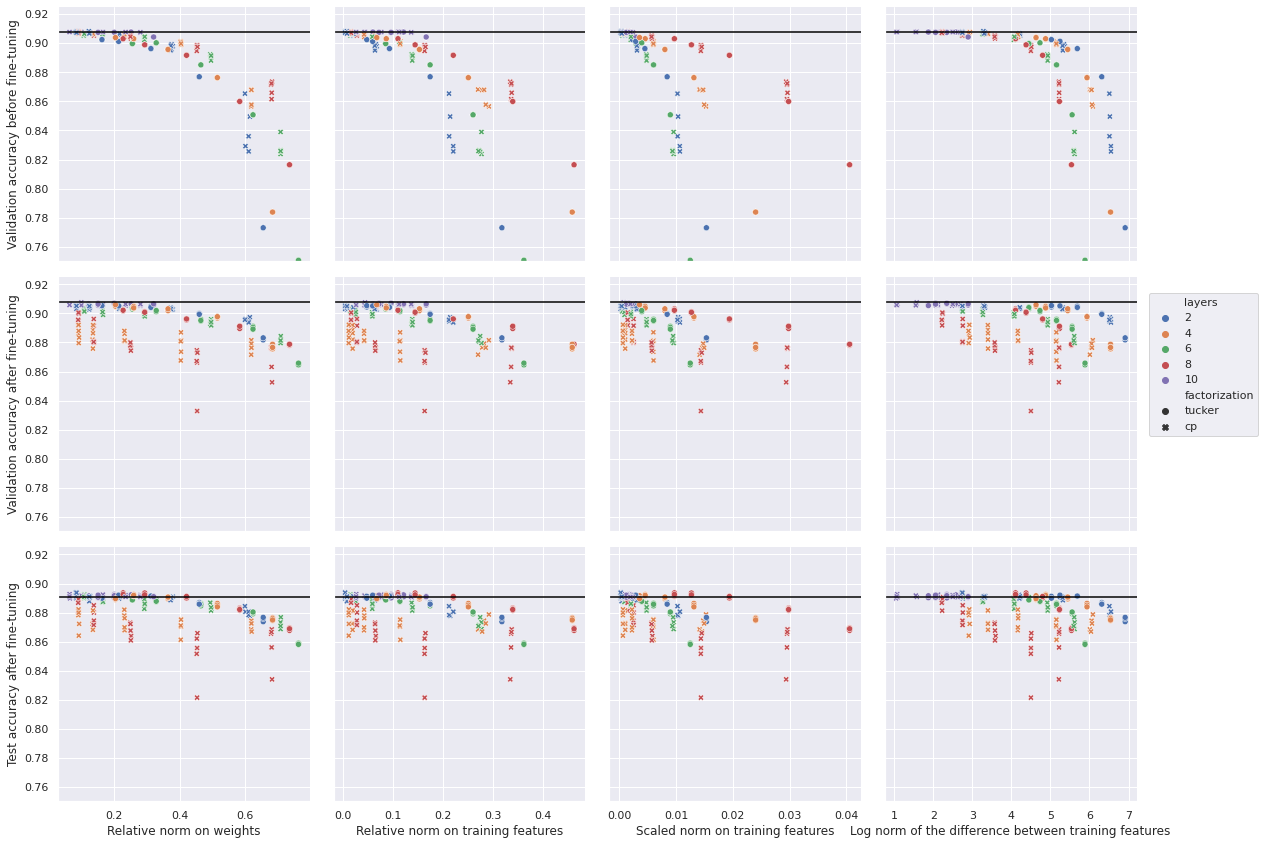

In [86]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"log_norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=ylim)
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

g.savefig("../../plots/cifar10/gar/gar_c10_scatter_errors_performances_layers_factorizations")

In [87]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


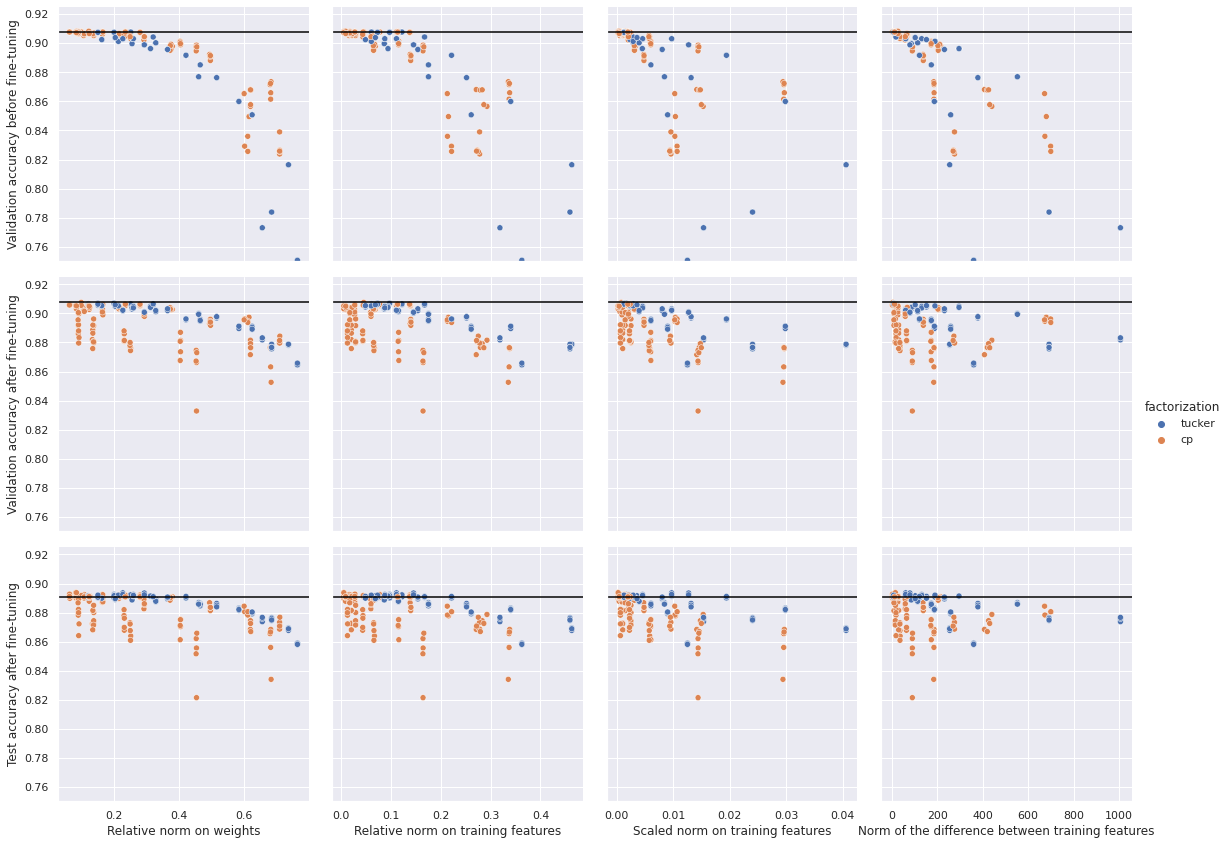

In [88]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="factorization",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

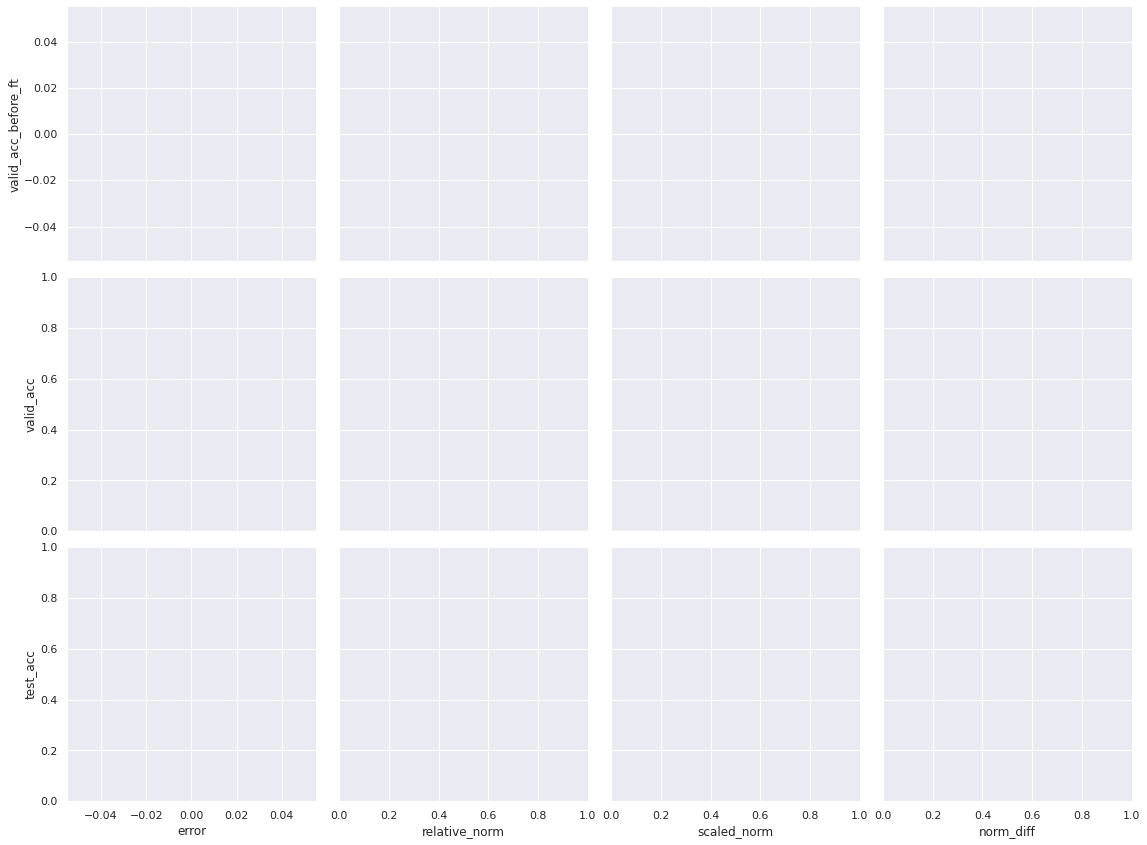

In [89]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="fact_layers",
    height=4,
    hue_order=[
        'cp-15','tucker-15','cp-19','tucker-19','cp-28','tucker-28','cp-38','tucker-38',
        'cp-41','tucker-41','cp-44','tucker-44','cp-60','tucker-60','cp-63','tucker-63',
    ]
    # palette=['b','orange']
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

In [92]:
df

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,...,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact,log_norm_diff,log_test_acc
0,conv2,2,0.162229,2,tucker,0.90,0.9062,0.9026,553952,0.8900,...,152.337169,3158.132243,65536.0,0.048261,0.002324,tucker-0.9,tucker-2,2-tucker,5.026096,-0.116534
1,conv2,2,0.162229,2,tucker,0.90,0.9060,0.9026,553952,0.8905,...,152.337076,3158.132243,65536.0,0.048261,0.002324,tucker-0.9,tucker-2,2-tucker,5.026096,-0.115972
2,conv3,4,0.134625,4,cp,0.75,0.8888,0.9070,539435,0.8728,...,30.008520,1506.304621,28800.0,0.019925,0.001042,cp-0.75,cp-4,4-cp,3.401481,-0.136049
3,conv2,2,0.125842,2,cp,0.75,0.9044,0.9076,548588,0.8914,...,28.002705,3158.132243,65536.0,0.008862,0.000427,cp-0.75,cp-2,2-cp,3.332301,-0.114962
4,conv4,6,0.464770,6,tucker,0.50,0.8960,0.8852,483277,0.8861,...,173.677206,993.765087,28800.0,0.174963,0.006030,tucker-0.5,tucker-6,6-tucker,5.157198,-0.120925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,conv4,6,0.292957,6,cp,0.50,0.8996,0.9046,484089,0.8861,...,59.034729,993.765087,28800.0,0.059466,0.002050,cp-0.5,cp-6,6-cp,4.078126,-0.120925
246,conv2,2,0.123629,2,cp,0.75,0.9050,0.9068,548588,0.8910,...,27.363409,3158.132243,65536.0,0.008659,0.000418,cp-0.75,cp-2,2-cp,3.309207,-0.115411
247,conv5,8,0.292971,8,tucker,0.75,0.9008,0.8990,521728,0.8922,...,79.692494,550.282592,6272.0,0.144972,0.012706,tucker-0.75,tucker-8,8-tucker,4.378175,-0.114065
248,conv3,4,0.203585,4,tucker,0.90,0.9060,0.9040,549840,0.8896,...,102.769564,1506.304621,28800.0,0.068253,0.003568,tucker-0.9,tucker-4,4-tucker,4.632489,-0.116983


# Kendals tau

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

In [22]:
def p_to_asterisks(p):
    """
    Estimates are significantly different from zero at 1\% significance level, 
    unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), 
    or not significantly different from zero (***).
    """
    if p < 0.01:
        asterisk = ""
    elif p < 0.05:
        asterisk = "*"
    elif p < 0.1:
        asterisk = "**"
    else:
        asterisk = "***"
    return asterisk

In [23]:
from scipy.stats.mstats_basic import kendalltau
from functools import partial

kendalltau_a = partial(kendalltau, use_ties=False, use_missing=False, method='auto')
# kendalltau(x, y, use_ties=True, use_missing=False, method='auto')

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names


metrics=['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff','layers']
# errors = ['relative_norm_weight','scaled_norm_weight','diff_norm_weight', 'relative_norm','scaled_norm','norm_diff','layers']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_kt = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = kendalltau_a(df[error], df[metric])
        df_kt[error][metric] = "{:.2f}{}".format(corr,p_to_asterisks(p))

In [24]:
df_kt

,relative_norm_weight,relative_norm,scaled_norm_weight,scaled_norm,diff_norm_weight,norm_diff,layers
log_valid_error_before_ft,0.78,0.65,0.71,0.70,0.74,0.75,-0.23
log_valid_error,0.56,0.44,0.47,0.52,0.60,0.47,-0.13
log_test_error_before_ft,0.74,0.63,0.66,0.65,0.68,0.69,-0.21
log_test_error,0.52,0.40,0.43,0.43,0.51,0.43,-0.13


In [25]:
# df_kt.to_pickle("./tables/kt_gar_c10_classification_error.zip")

In [26]:
neat_table_indices = {
    'valid_acc_before_ft': "Val. before f.t.",
    'valid_acc': "Val. after f.t.",
    'test_acc': "Test after f.t.",
}
neat_table_columns = {
    'error': "Relative-weights",
    'relative_norm': "Relative-features",
    'scaled_norm': "Scaled-features",
    'norm_diff': "Difference-features"}
df_kt.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)
df_kt

,relative_norm_weight,Relative-features,scaled_norm_weight,Scaled-features,diff_norm_weight,Difference-features,layers
log_valid_error_before_ft,0.78,0.65,0.71,0.70,0.74,0.75,-0.23
log_valid_error,0.56,0.44,0.47,0.52,0.60,0.47,-0.13
log_test_error_before_ft,0.74,0.63,0.66,0.65,0.68,0.69,-0.21
log_test_error,0.52,0.40,0.43,0.43,0.51,0.43,-0.13


In [27]:
print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Kendall's tau from GaripovNet on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='kt_gar_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from GaripovNet on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{kt_gar_c10_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & Relative-features & scaled\_norm\_weight & Scaled-features & diff\_norm\_weight & Difference-features & layers \\
\midrule
log\_valid\_error\_before\_ft &                 0.78 &              0.65 &               0.71 &            0.70 &             0.74 &                0.75 &  -0.23 \\
log\_valid\_error           &                 0.56 &              0.44 &               0.47 &            0.52

In [28]:
df.layers.astype(str).unique()

array(['2', '4', '8', '6', '10'], dtype=object)

In [29]:
errors_metrics = []

for error in errors:
    for metric in metrics:
        errors_metrics.append(f'{error}-{metric}')

layers = ['2','4','6','8','10']

df_kt_layers = pd.DataFrame(
    index=errors_metrics,
    columns=layers,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau_a(df_layer[error], df_layer[metric])
            df_kt_layers[str(layer)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))
    

In [30]:
neat_table_indices_layers = {
    'error-valid_acc_before_ft': "Val. before f.t.-weight",
    'error-valid_acc': "Val. after f.t.-weight",
    'error-test_acc': "Test after f.t.-weight",

    'relative_norm-valid_acc_before_ft': "Val. before f.t.-rel. feat.",
    'relative_norm-valid_acc': "Val. after f.t.-rel. feat.",
    'relative_norm-test_acc': "Test after f.t.-rel. feat.",

    'scaled_norm-valid_acc_before_ft': "Val. before f.t.-sc. feat",
    'scaled_norm-valid_acc': "Val. after f.t.-sc. feat",
    'scaled_norm-test_acc': "Test after f.t.-sc. feat",

    'norm_diff-valid_acc_before_ft': "Val. before f.t.-diff. feat",
    'norm_diff-valid_acc': "Val. after f.t.-diff. feat",
    'norm_diff-test_acc': "Test after f.t.-diff. feat",
}

df_kt_layers.rename(index=neat_table_indices_layers, inplace=True)
df_kt_layers

,2,4,6,8,10
relative_norm_weight-log_valid_error_before_ft,0.85,0.89,0.82,0.86,0.48
relative_norm_weight-log_valid_error,0.63,0.41,0.72,0.49,0.18*
relative_norm_weight-log_test_error_before_ft,0.86,0.79,0.84,0.81,0.01***
relative_norm_weight-log_test_error,0.58,0.27,0.73,0.44,0.15**
relative_norm-log_valid_error_before_ft,0.84,0.93,0.89,0.91,0.47
relative_norm-log_valid_error,0.55,0.36,0.72,0.45,0.17*
relative_norm-log_test_error_before_ft,0.86,0.79,0.92,0.86,0.02***
relative_norm-log_test_error,0.57,0.23,0.76,0.36,0.15**
scaled_norm_weight-log_valid_error_before_ft,0.85,0.89,0.82,0.86,0.48
scaled_norm_weight-log_valid_error,0.63,0.41,0.72,0.48,0.18*


In [31]:
print(df_kt_layers.to_latex(
    position='htbp', 
    caption="Kendall's tau from GaripovNet on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='tab:kt_gar_c10_errors_performances_layers',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from GaripovNet on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{tab:kt_gar_c10_errors_performances_layers}
\begin{tabular}{llllll}
\toprule
{} &        2 &        4 &        6 &        8 &       10 \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &     0.85 &     0.89 &     0.82 &     0.86 &     0.48 \\
relative\_norm\_weight-log\_valid\_error           

In [32]:
df.factorization.unique()

array(['tt', 'tucker', 'cp'], dtype=object)

In [33]:
factorizations = ['cp', 'tucker', 'tt']

df_kt_factorizations = pd.DataFrame(
    index=errors_metrics,
    columns=factorizations,
)

for fact in df.factorization.unique():
    df_ = df[df.factorization==fact]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau(df_[error], df_[metric])
            df_kt_factorizations[str(fact)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))

df_kt_factorizations.rename(index=neat_table_indices_layers, inplace=True)

print(df_kt_factorizations.to_latex(
    position='htbp', 
    caption="Kendall's tau from GaripovNet on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='tab:kt_gar_c10_errors_performances_factorization',
))
    

\begin{table}[htbp]
\centering
\caption{Kendall's tau from GaripovNet on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{tab:kt_gar_c10_errors_performances_factorization}
\begin{tabular}{llll}
\toprule
{} &        cp &  tucker &      tt \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &      0.67 &    0.80 &    0.91 \\
relative\_norm\_weight-log\_valid\_error           &      0.36 &    0.77 &    0.83 \

## Mean and std

In [34]:
metrics=['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

In [35]:
df['actual_rank'] = df['rank']
rank_conf = {
    10: [
        0.16,
        0.31,
        0.18,
        0.18,
        0.18,
    ],
    25: [
        0.61,
        1.43,
        1.22,
        1.22,
        1.22,
    ],
    50: [
        2.31,
        3.52,
        4.57,
        4.57,
        4.57,
    ],
    75: [
        6.60,
        7.79,
        12.99,
        12.99,
        12.99,
    ],
    90: [
        10.33,
        12.28,
        20.07,
        20.07,
        20.07,
    ]
}
for k,v in rank_conf.items():
    print(k,v)
    df.loc[df['rank'].isin(v), 'actual_rank'] = k/100

10 [0.16, 0.31, 0.18, 0.18, 0.18]
25 [0.61, 1.43, 1.22, 1.22, 1.22]
50 [2.31, 3.52, 4.57, 4.57, 4.57]
75 [6.6, 7.79, 12.99, 12.99, 12.99]
90 [10.33, 12.28, 20.07, 20.07, 20.07]


In [36]:
from tddl.post_processing.kendalls_tau import split_into_run, calculate_kendalls_tau_per_run, mean_std_over_runs

dfs = split_into_run(df, 5)
df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_kt_mean_std = mean_std_over_runs(df_kts, errors=errors, metrics=metrics)
df_kt_mean_std

,relative_norm_weight,relative_norm,scaled_norm_weight,scaled_norm,diff_norm_weight,norm_diff
log_valid_error_before_ft,0.79±0.00,0.66±0.01,0.72±0.01,0.71±0.01,0.75±0.01,0.76±0.01
log_valid_error,0.57±0.01,0.44±0.01,0.48±0.02,0.53±0.01,0.61±0.01,0.48±0.01
log_test_error_before_ft,0.75±0.01,0.64±0.01,0.66±0.01,0.66±0.01,0.69±0.01,0.70±0.01
log_test_error,0.52±0.02,0.41±0.02,0.44±0.02,0.44±0.02,0.52±0.01,0.44±0.02


In [37]:
# df_kt_mean_std.to_pickle("./tables/kt_gar_c10_mean_std.zip")

In [38]:
from tddl.post_processing.kendalls_tau import dfs_for_bar

df_bar = dfs_for_bar(df_kts, dataset='CIFAR-10', model='GaripovNet', 
    errors=errors, 
    metrics=metrics,
)
df_bar.to_pickle("./tables/kta_gar_c10_bar_log_error.zip")

In [39]:
df.actual_rank

0      0.25
1      0.90
2      0.90
3      0.75
4      0.25
       ... 
370    0.25
371    0.25
372    0.90
373    0.25
374    0.25
Name: actual_rank, Length: 375, dtype: float64

In [40]:
(df.actual_rank.isin([0.75, 0.9]))

0      False
1       True
2       True
3       True
4      False
       ...  
370    False
371    False
372     True
373    False
374    False
Name: actual_rank, Length: 375, dtype: bool

In [41]:
dfs = split_into_run(df[~df.actual_rank.isin([0.75, 0.9])], 5)
df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_bar = dfs_for_bar(df_kts, dataset='CIFAR-10', model='GaripovNet', 
    errors=errors, 
    metrics=metrics,
)
df_bar.to_pickle("./tables/kta_gar_c10_bar_log_error_ex-r.zip")

## per Layer

In [42]:
# from scipy.stats import kendalltau
from tddl.post_processing.kendalls_tau import kendalltau_a

dfs = split_into_run(df, 5)
# n = 0
# layer = 63
model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm'] # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
layers = [2,4,6,8,10]
N = 5

df_layers_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error'])
df_means = pd.DataFrame(columns=approxs, index=performs)
df_mean_layers = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(layers),N))

for p, perform in enumerate(performs):
    print(perform)
    for a, approx in enumerate(approxs):
        print(approx)
        arr = np.zeros((len(layers),N))
        for n in range(N):
            cs = np.zeros(len(layers))
            for l, layer in enumerate(layers):
                df_n = dfs[n]
                df_n_l = df_n.loc[df_n.layers == layer]
                # print(df_n_l)
                c, _ = kendalltau_a(df_n_l[perform],df_n_l[approx])
                print(f"Layer: {layer}, run: {n}, Kendall's tau {c}")
                df_layers_ = df_layers_.append({
                    'layer':layer,
                    'run':n,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'model': model,
                    'dataset': dataset,
                }, ignore_index=True)
                array[p, a, l, n] = c
                arr[l,n] = c 
                cs[l] = c
            df_mean_layers = df_mean_layers.append({
                'run':n,
                'performance_metric':perform,
                'approximation_error':approx,
                'kt': cs.mean(),
                'model': model,
                'dataset': dataset,
            }, ignore_index=True)
        df_means[approx][perform] = arr.mean()

# df_layers_.to_pickle("./tables/kta_gar_c10_bar_log_error_layers.zip")
# df_mean_layers.to_pickle("./tables/kta_gar_c10_bar_log_error_layers_mean.zip")


log_valid_error_before_ft
relative_norm_weight
Layer: 2, run: 0, Kendall's tau 0.9047619047619048
Layer: 4, run: 0, Kendall's tau 0.9333333333333333
Layer: 6, run: 0, Kendall's tau 0.8571428571428571
Layer: 8, run: 0, Kendall's tau 0.9047619047619048
Layer: 10, run: 0, Kendall's tau 0.5714285714285714
Layer: 2, run: 1, Kendall's tau 0.8952380952380953
Layer: 4, run: 1, Kendall's tau 0.9523809523809523
Layer: 6, run: 1, Kendall's tau 0.8666666666666667
Layer: 8, run: 1, Kendall's tau 0.9142857142857143
Layer: 10, run: 1, Kendall's tau 0.41904761904761906
Layer: 2, run: 2, Kendall's tau 0.9047619047619048
Layer: 4, run: 2, Kendall's tau 0.9333333333333333
Layer: 6, run: 2, Kendall's tau 0.8476190476190476
Layer: 8, run: 2, Kendall's tau 0.8952380952380953
Layer: 10, run: 2, Kendall's tau 0.47619047619047616
Layer: 2, run: 3, Kendall's tau 0.8952380952380953
Layer: 4, run: 3, Kendall's tau 0.9333333333333333
Layer: 6, run: 3, Kendall's tau 0.8857142857142857
Layer: 8, run: 3, Kendall's ta

In [44]:
# from scipy.stats import kendalltau
dfs = split_into_run(df, 5)
# n = 0
# layer = 63
model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm'] # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
factorizations = ['cp','tucker','tt']
N = 5

df_factorizations_ = pd.DataFrame(columns=['kt','factorization', 'run', 'performance_metric', 'approximation_error','model','dataset'])
df_means = pd.DataFrame(columns=approxs, index=performs)
df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(factorizations),N))

for p, perform in enumerate(performs):
    print(perform)
    for a, approx in enumerate(approxs):
        print(approx)
        arr = np.zeros((len(factorizations),N))
        for n in range(N):
            cs = np.zeros(len(factorizations))
            for l, factorization in enumerate(factorizations):
                df_n = dfs[n]
                df_n_l = df_n.loc[df_n.factorization == factorization]
                # print(df_n_l)
                c, _ = kendalltau_a(df_n_l[perform],df_n_l[approx])
                print(f"factorization: {factorization}, run: {n}, Kendall's tau {c}")
                df_factorizations_ = df_factorizations_.append({
                    'factorization':factorization,
                    'run':n,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'model': model,
                    'dataset': dataset,
                }, ignore_index=True)
                array[p, a, l, n] = c
                arr[l,n] = c 
                cs[l] = c
            df_mean_factorizations = df_mean_factorizations.append({
                'run':n,
                'performance_metric':perform,
                'approximation_error':approx,
                'kt': cs.mean(),
                'kt_mean': cs.mean(),
                'kt_std': cs.std(),
                'model': model,
                'dataset': dataset,
            }, ignore_index=True)
        df_means[approx][perform] = arr.mean()

# df_factorizations_.to_pickle("./tables/kta_rn18_c10_bar_log_error_factorizations.zip")
# df_mean_factorizations.to_pickle("./tables/kta_gar_c10_bar_log_error_factorizations_mean.zip")

log_valid_error_before_ft
relative_norm_weight
factorization: cp, run: 0, Kendall's tau 0.6533333333333333
factorization: tucker, run: 0, Kendall's tau 0.8033333333333333
factorization: tt, run: 0, Kendall's tau 0.9033333333333333
factorization: cp, run: 1, Kendall's tau 0.6966666666666667
factorization: tucker, run: 1, Kendall's tau 0.8033333333333333
factorization: tt, run: 1, Kendall's tau 0.9033333333333333
factorization: cp, run: 2, Kendall's tau 0.6866666666666666
factorization: tucker, run: 2, Kendall's tau 0.8033333333333333
factorization: tt, run: 2, Kendall's tau 0.9033333333333333
factorization: cp, run: 3, Kendall's tau 0.7466666666666667
factorization: tucker, run: 3, Kendall's tau 0.8033333333333333
factorization: tt, run: 3, Kendall's tau 0.9033333333333333
factorization: cp, run: 4, Kendall's tau 0.6333333333333333
factorization: tucker, run: 4, Kendall's tau 0.8033333333333333
factorization: tt, run: 4, Kendall's tau 0.9033333333333333
relative_norm
factorization: cp, 

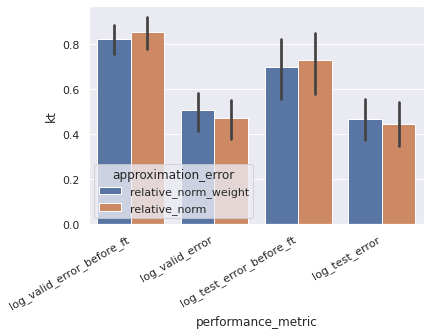

In [45]:
ax = sns.barplot(
    x='performance_metric',
    y='kt',
    hue='approximation_error',
    data=df_layers_,
    # ci="sd", palette="dark", alpha=.6, height=6,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')
fig = ax.get_figure()

## Kendalls tau varying layers

In [46]:
df[['rank','actual_rank']]

,rank,actual_rank
0,0.61,0.25
1,0.90,0.90
2,0.90,0.90
3,0.75,0.75
4,1.22,0.25
...,...,...
370,1.22,0.25
371,0.61,0.25
372,0.90,0.90
373,1.43,0.25


In [47]:
dfs[0].columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'test_acc_before_ft', 'n_param_fact', 'test_acc',
       'lr', 'optimizer', 'norm_diff', 'norm_b', 'n_b', 'relative_norm',
       'scaled_norm', 'fact_rank', 'fact_layers', 'layers_fact',
       'test_error_before_ft', 'test_error', 'valid_error_before_ft',
       'valid_error', 'log_test_error_before_ft', 'log_test_error',
       'log_valid_error_before_ft', 'log_valid_error', 'actual_rank'],
      dtype='object')

In [50]:
dfs = split_into_run(df, 5)

model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_layers_ = pd.DataFrame(columns=['kt','factorization', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
factorizations = df.factorization.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                for f in factorizations:
                    df_i_r_f = df_i_r[df_i_r.factorization == f]
                    # select rows where factorization == d
                    # kt over df_layers
                    c, _ = kendalltau_a(df_i_r_f[perform],df_i_r_f[approx])
                    df_layers_ = df_layers_.append({
                        'factorization':f,
                        'run':n,
                        'performance_metric':perform,
                        'approximation_error':approx,
                        'kt': c,
                        'model': model,
                        'dataset': dataset,
                        'rank': r,
                        'run': i,
                    }, ignore_index=True)

# df_layers_.to_pickle("./tables/kta_gar_c10_bar_log_error_across_layers.zip")

In [51]:
df[
    ~df.actual_rank.isin([0.75, 0.9])
    # & (df['performance_metric'] == 'Test error before fine-tuning')
    & (df['approximation_error'].isin(['Relative Weights','Relative Features']))
    & (df['model & dataset'] == 'GaripovNet & CIFAR-10')
]

KeyError: 'approximation_error'

In [ ]:
dfs = split_into_run(df[~df.actual_rank.isin([0.75, 0.9])], 5)

model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_layers_ = pd.DataFrame(columns=['kt','factorization', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
factorizations = df.factorization.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                for f in factorizations:
                    df_i_r_f = df_i_r[df_i_r.factorization == f]
                    # select rows where factorization == d
                    # kt over df_layers
                    c, _ = kendalltau_a(df_i_r_f[perform],df_i_r_f[approx])
                    df_layers_ = df_layers_.append({
                        'factorization':f,
                        'run':n,
                        'performance_metric':perform,
                        'approximation_error':approx,
                        'kt': c,
                        'model': model,
                        'dataset': dataset,
                        'rank': r,
                        'run': i,
                    }, ignore_index=True)

# df_layers_.to_pickle("./tables/kta_gar_c10_bar_log_error_across_layers_ex-r.zip")

In [ ]:
df_layers_

,kt,factorization,run,performance_metric,approximation_error,model,dataset,rank
0,0.8,tt,0,log_valid_error_before_ft,relative_norm_weight,GaripovNet,CIFAR-10,0.25
1,1.0,tucker,0,log_valid_error_before_ft,relative_norm_weight,GaripovNet,CIFAR-10,0.25
2,0.6,cp,0,log_valid_error_before_ft,relative_norm_weight,GaripovNet,CIFAR-10,0.25
3,0.9,tt,0,log_valid_error_before_ft,relative_norm_weight,GaripovNet,CIFAR-10,0.90
4,0.6,tucker,0,log_valid_error_before_ft,relative_norm_weight,GaripovNet,CIFAR-10,0.90
...,...,...,...,...,...,...,...,...
1795,0.2,tucker,4,log_test_error,norm_diff,GaripovNet,CIFAR-10,0.50
1796,0.2,cp,4,log_test_error,norm_diff,GaripovNet,CIFAR-10,0.50
1797,0.0,tt,4,log_test_error,norm_diff,GaripovNet,CIFAR-10,0.10
1798,0.2,tucker,4,log_test_error,norm_diff,GaripovNet,CIFAR-10,0.10


In [52]:
df.layers.unique() # 'nr' 'layers'

[2, 4, 8, 6, 10]
Categories (5, int64): [2, 4, 8, 6, 10]

In [53]:
dfs = split_into_run(df, 5)

model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_facts_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

# array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
layers = df.layers.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                for l in layers:
                    df_i_r_l = df_i_r[df_i_r.layers == l]
                    # select rows where factorization == d
                    # kt over df_layers
                    c, _ = kendalltau_a(df_i_r_l[perform],df_i_r_l[approx])
                    df_facts_ = df_facts_.append({
                        'layer':l,
                        'run':n,
                        'performance_metric':perform,
                        'approximation_error':approx,
                        'kt': c,
                        'model': model,
                        'dataset': dataset,
                        'rank': r,
                        'run': i,
                    }, ignore_index=True)

# df_facts_.to_pickle("./tables/kta_gar_c10_bar_log_error_across_facts.zip")

In [54]:
dfs = split_into_run(df[~df.actual_rank.isin([0.75, 0.9])], 5)

model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_facts_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

# array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
layers = df.layers.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                for l in layers:
                    df_i_r_l = df_i_r[df_i_r.layers == l]
                    # select rows where factorization == d
                    # kt over df_layers
                    c, _ = kendalltau_a(df_i_r_l[perform],df_i_r_l[approx])
                    df_facts_ = df_facts_.append({
                        'layer':l,
                        'run':n,
                        'performance_metric':perform,
                        'approximation_error':approx,
                        'kt': c,
                        'model': model,
                        'dataset': dataset,
                        'rank': r,
                        'run': i,
                    }, ignore_index=True)

# df_facts_.to_pickle("./tables/kta_gar_c10_bar_log_error_across_facts_ex-r.zip")

In [62]:
df['actual_rank'].unique()

array([0.25, 0.9 , 0.75, 0.5 , 0.1 ])

In [66]:
dfs = split_into_run(df, 5)

model = 'GaripovNet'
dataset = 'CIFAR-10'
performs = ['log_test_error_before_ft','log_test_error'] # 'log_valid_error_before_ft','log_valid_error',
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_layer_fact_ = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

# array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
# layers = df.layers.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                # for l in layers:
                #     df_i_r_l = df_i_r[df_i_r.layers == l]
                    # select rows where factorization == d
                    # kt over df_layers
                c, _ = kendalltau_a(df_i_r[perform],df_i_r[approx])
                print(f'{approx=}', f'{r=}', f'{i=}', f'{c=}')
                df_layer_fact_ = df_layer_fact_.append({
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'model': model,
                    'dataset': dataset,
                    'rank': r,
                    'run': i,
                }, ignore_index=True)

df_layer_fact_.to_pickle("./tables/kta_gar_c10_bar_log_error_across_layer_facts_incl75-9.zip")

approx='relative_norm_weight' r=0.25 i=0 c=0.8666666666666667
approx='relative_norm_weight' r=0.9 i=0 c=0.5047619047619047
approx='relative_norm_weight' r=0.75 i=0 c=0.6476190476190476
approx='relative_norm_weight' r=0.5 i=0 c=0.6666666666666666
approx='relative_norm_weight' r=0.1 i=0 c=0.819047619047619
approx='relative_norm_weight' r=0.25 i=1 c=0.8095238095238095
approx='relative_norm_weight' r=0.9 i=1 c=0.580952380952381
approx='relative_norm_weight' r=0.75 i=1 c=0.6761904761904762
approx='relative_norm_weight' r=0.5 i=1 c=0.7428571428571429
approx='relative_norm_weight' r=0.1 i=1 c=0.8285714285714286
approx='relative_norm_weight' r=0.25 i=2 c=0.8857142857142857
approx='relative_norm_weight' r=0.9 i=2 c=0.5523809523809524
approx='relative_norm_weight' r=0.75 i=2 c=0.638095238095238
approx='relative_norm_weight' r=0.5 i=2 c=0.7142857142857143
approx='relative_norm_weight' r=0.1 i=2 c=0.8095238095238095
approx='relative_norm_weight' r=0.25 i=3 c=0.8666666666666667
approx='relative_nor

# Pearson Correlation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [34]:
from scipy.stats import pearsonr

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# errors = ['error', 'relative_norm','scaled_norm','norm_diff']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_pr = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = pearsonr(df[error], df[metric])
        df_pr[error][metric] = corr

In [33]:
df_pr.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)

print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Pearson's rho from GaripovNet on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='pr_gar_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Pearson's rho from GaripovNet on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{pr_gar_c10_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & Relative-features & scaled\_norm\_weight & Scaled-features & diff\_norm\_weight & Difference-features & layers \\
\midrule
log\_valid\_error\_before\_ft &                 0.83 &              0.73 &               0.71 &            0.73 &             0.76 &                0.74 &  -0.23 \\
log\_valid\_error           &                 0.66 &              0.56 &               0.54 &            0.59

In [34]:
df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

In [35]:
df_pr_layers

,relative_norm_weight-log_valid_error_before_ft,relative_norm_weight-log_valid_error,relative_norm_weight-log_test_error_before_ft,relative_norm_weight-log_test_error,relative_norm-log_valid_error_before_ft,relative_norm-log_valid_error,relative_norm-log_test_error_before_ft,relative_norm-log_test_error,scaled_norm_weight-log_valid_error_before_ft,scaled_norm_weight-log_valid_error,...,diff_norm_weight-log_test_error_before_ft,diff_norm_weight-log_test_error,norm_diff-log_valid_error_before_ft,norm_diff-log_valid_error,norm_diff-log_test_error_before_ft,norm_diff-log_test_error,layers-log_valid_error_before_ft,layers-log_valid_error,layers-log_test_error_before_ft,layers-log_test_error
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


KeyError: 'error'

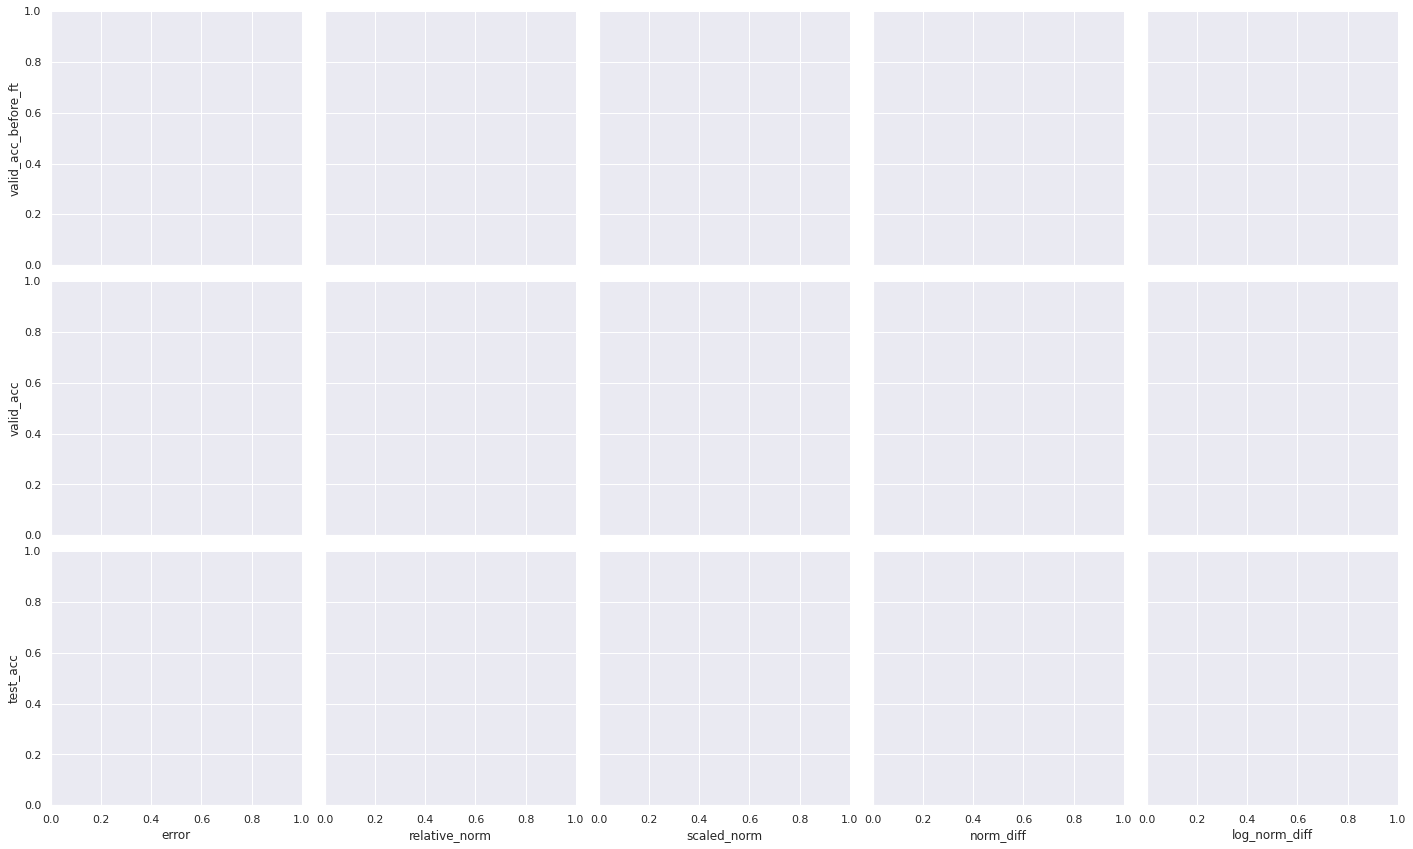

In [36]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm","norm_diff" ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

# g.savefig("../../plots/cifar10/gar/gar_c10_linear_errors_performances_layers")

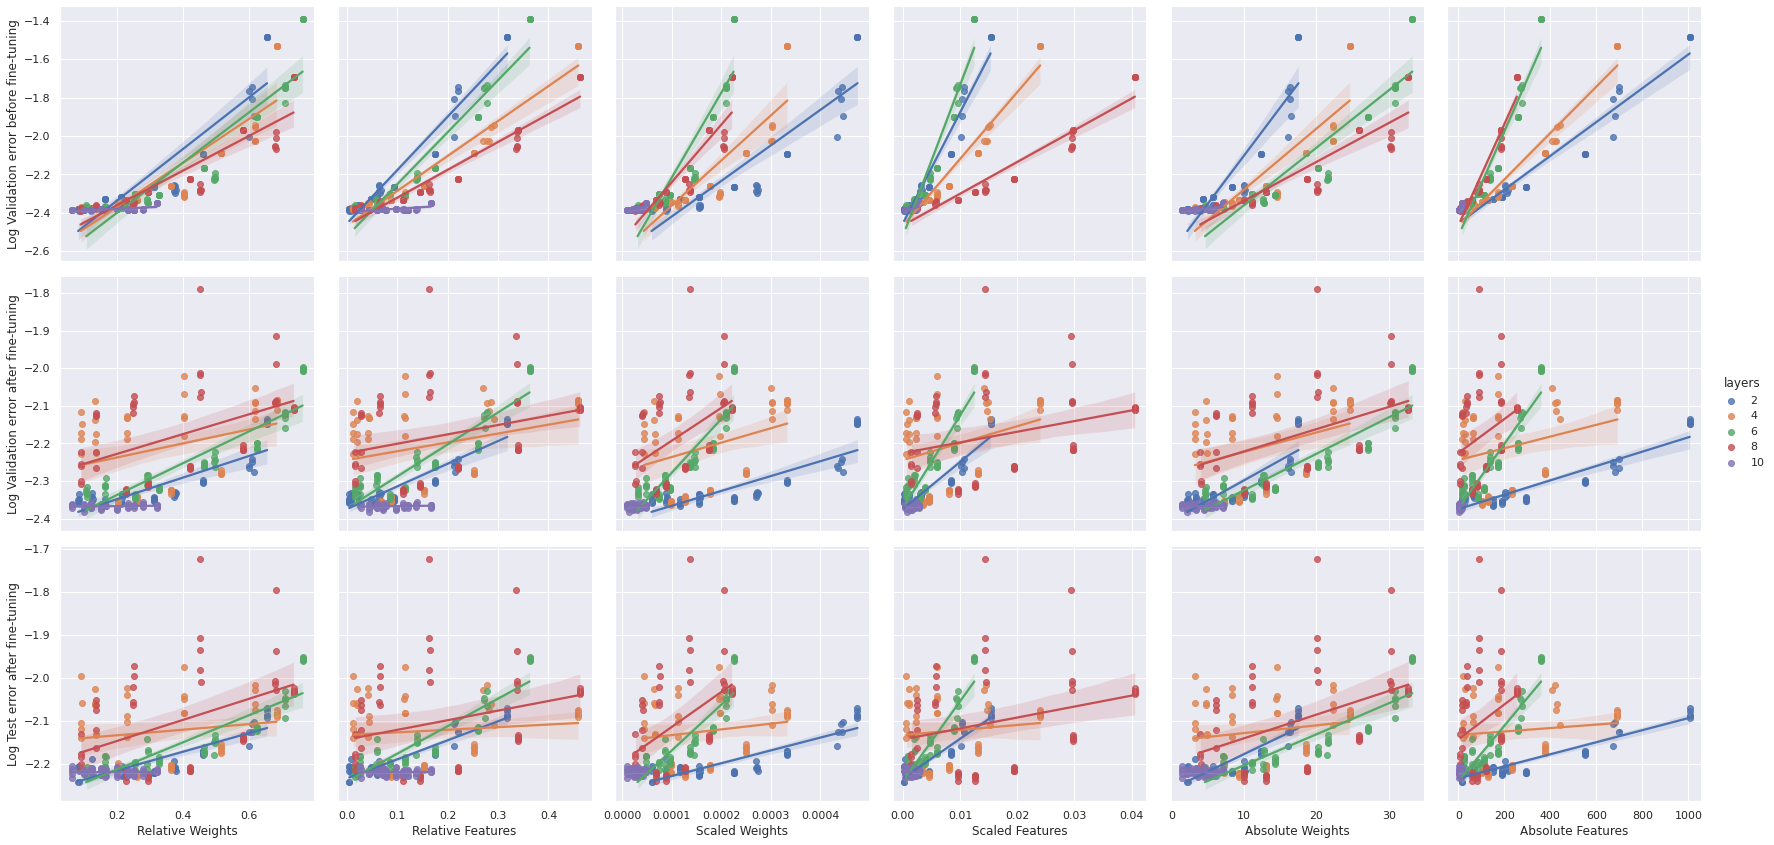

In [ ]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'relative_norm_weight': 'Relative Weights',
    'scaled_norm_weight': 'Scaled Weights',
    'diff_norm_weight': 'Absolute Weights',
    'relative_norm': 'Relative Features',
    'scaled_norm': 'Scaled Features',
    'norm_diff': 'Absolute Features',
    'log_valid_error_before_ft': 'Log Validation error before fine-tuning',
    'log_valid_error': 'Log Validation error after fine-tuning',
    'log_test_error': 'Log Test error after fine-tuning'
    # 'log_norm_diff': 'Log norm of the Absolute between training features',
}

metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']


g = sns.PairGrid(
    df,
    y_vars=metrics, # ["valid_error_before_ft", "log_valid_error","log_test_error"], 
    x_vars=errors, # ["relative_norm", "scaled_norm","norm_diff"],# ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
# g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(6):
        gax = g.axes[i][j]
        # gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/gar/gar_c10_linear_errors_performances_layers")

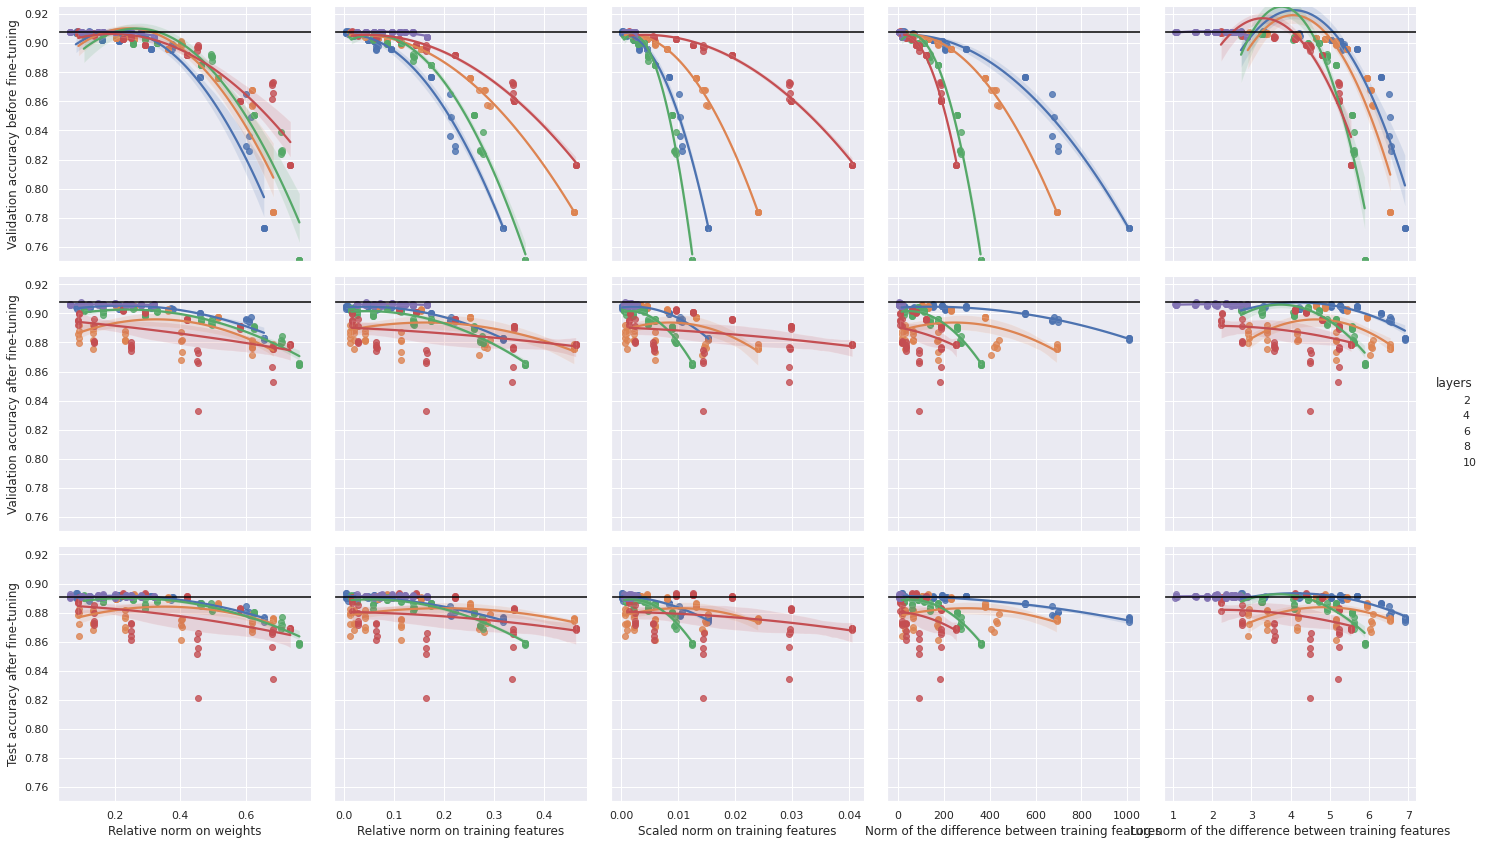

In [ ]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff","log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(lambda x, y, **kwargs: sns.regplot(x=x,y=y,order=2)) # sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')
g.set(ylim=ylim)
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

# plt.legend(
#     bbox_to_anchor=(1.05, 1,1,1),
#     loc='upper left', borderaxespad=0.
# )
g.savefig("../../plots/cifar10/gar/gar_c10_poly2_errors_performances_layers")

In [ ]:
from statsmodels.api import OLS

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_ols = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        res = OLS(df[metric], df[error], hasconst=True).fit()
        print(res.summary())
        # df_kt[error][metric] = (corr, p)

                             OLS Regression Results                            
Dep. Variable:     valid_acc_before_ft   R-squared:                   -1149.942
Model:                             OLS   Adj. R-squared:              -1149.942
Method:                  Least Squares   F-statistic:                       nan
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):                nan
Time:                         14:15:12   Log-Likelihood:                -109.90
No. Observations:                  260   AIC:                             221.8
Df Residuals:                      259   BIC:                             225.4
Df Model:                            0                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
error          1.5496      0.043     36.46

In [37]:



df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

In [38]:
df_pr_layers

,relative_norm_weight-log_valid_error_before_ft,relative_norm_weight-log_valid_error,relative_norm_weight-log_test_error_before_ft,relative_norm_weight-log_test_error,relative_norm-log_valid_error_before_ft,relative_norm-log_valid_error,relative_norm-log_test_error_before_ft,relative_norm-log_test_error,scaled_norm_weight-log_valid_error_before_ft,scaled_norm_weight-log_valid_error,...,diff_norm_weight-log_test_error_before_ft,diff_norm_weight-log_test_error,norm_diff-log_valid_error_before_ft,norm_diff-log_valid_error,norm_diff-log_test_error_before_ft,norm_diff-log_test_error,layers-log_valid_error_before_ft,layers-log_valid_error,layers-log_test_error_before_ft,layers-log_test_error
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
